In [19]:
# Import the data science stack
import numpy as np
import pandas as pd
#import tensorflow as tf
import pickle

from sklearn.utils import shuffle

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# File system access
import os

# Image importing
import csv
import cv2

# Tracking progress
from tqdm import tqdm

Read in images - takes about 15 minutes

In [84]:
import cv2
import os

def load_images_from_folder(folder, dim):
    img_array = []
    
    # use tqdm to track progress
    # opens each image iteratively from folder
    for filename in tqdm(os.listdir(folder), position=0, leave=True):
        
        # reads image 
        img = cv2.imread(os.path.join(folder,filename))
        
        if img is not None:
            # convert to gray scale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # resize image
            resized = cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)

            # append image
            img_array.append(resized)
    
    return img_array
folder="/home/ubuntu/data"

In [85]:
dim = (256, 256)

load_images_from_folder(folder, dim)

100%|██████████| 194922/194922 [17:37<00:00, 184.41it/s]


[array([[45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45]], dtype=uint8),
 array([[37, 37, 37, ..., 37, 37, 37],
        [37, 37, 37, ..., 38, 37, 37],
        [37, 37, 38, ..., 51, 47, 37],
        ...,
        [37, 37, 42, ..., 48, 39, 37],
        [37, 37, 37, ..., 52, 37, 37],
        [37, 37, 37, ..., 37, 37, 37]], dtype=uint8),
 array([[ 44,  45,  44, ...,  38,  38,  38],
        [ 46,  43,  45, ...,  41,  38,  38],
        [ 41,  44,  39, ...,  43,  43,  38],
        ...,
        [255, 146,  63, ...,  46,  38,  38],
        [166, 255, 150, ...,  38,  38,  38],
        [ 75, 160, 255, ...,  38,  38,  38]], dtype=uint8),
 array([[38, 38, 40, ..., 45, 42, 44],
        [38, 44, 46, ..., 46, 45, 45],
        [39, 55, 44, ..., 42, 45, 43],
        ...,
        [44, 46, 42, ..., 44, 40, 47],
        [

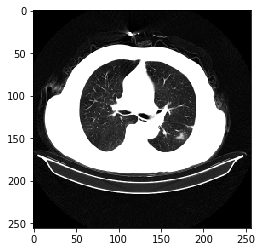

In [87]:
plt.imshow(img_array[20], cmap='gray')